In [29]:
import lmfit
from lmfit import Parameters,Minimizer
import random
import torch
from datetime import datetime
import os
from tqdm import tqdm
from utils_optimization.Set_up_dispersion_and_materials import set_up_dispersion_and_materials
from utils_optimization.functions_to_construct_objective_function import *
from utils_optimization.results_handling import save_results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [30]:
dtype = torch.float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Initialization of initial conditions
n = 10  # Number of slots for filters in each of the wheel
# Range of wavelengths points
wavelengths = torch.linspace(8000, 14000, n ** 2 - 1) * 1e-9  # Expressed in [m] as tmm_torch library requires
# Angles of incidence
angles = torch.linspace(0, 89, 90)
# Setting up material and dispersion models for simulation
Ti_mat, Au_mat, aSi_mat, env, subs = set_up_dispersion_and_materials(dtype, device)

In [31]:
def Objective_wrapper(params):
    """
    Lmfit wrapper of torch objective function.

     Args:
         params (lmfit.Parameters): parameters of thickness in lmfit compatible format

     Returns:
         residual_value (float): value obtained from torch defined objective function which was detached and projected to numpy format

     """
    # Converting lmfit.Parameters to torch.nn.Parameter
    param_tensor = lmfit_to_torch_values(params,dtype,device)

    # Global variables used for capturing value of objective function with each iteration
    global  Residuals_over, Values_of_bandwidth#,Jacobian, Hessian

    # Jacobian and Hessian calculations
    #Jacobian=torch.autograd.functional.jacobian(Objective_expanded,param_tensor).detach().numpy()
    #Hessian=torch.autograd.functional.hessian(Objective_expanded,param_tensor).detach().numpy()

    # Residual from true objective function
    residual_value=objective_bandwidth(param_tensor[:(n-1)*6],wavelengths,n,Au_mat,Ti_mat,aSi_mat,env,subs,angles,dtype,device,param_tensor[(n-1)*6:])

    # Detaching residual from computational graph and appending it to history of residuals
    residual_value = residual_value.detach().numpy()
    Residuals_over.append(residual_value)

    Values_of_bandwidth.append(torch.linalg.vector_norm(param_tensor[(n-1)*6:],ord=1).detach().numpy())

    return residual_value

In [32]:
# General loop for two-step optimization
# Defining parameters for the lmfit optimizer as first guess
params = Parameters()
# Thickness of the Ti
for i in range((n - 1) * 2):
    params.add(f'Ti_filter_{i + 1}', value=random.uniform(1e-9,10e-9),min=1e-9,max=10e-9)

# Thickness of the Au
for i in range((n - 1) * 2):
    params.add(f'Au_filter_{i + 1}', value=random.uniform(1e-9,10e-9),min=1e-9,max=10e-9)

# Thickness of the aSi
for i in range((n - 1) * 2):
    params.add(f'aSi_filter_{i + 1}', value=random.uniform(1000e-9, 10000e-9), min=1000e-9, max=10000e-9)

# Bandwidth of Lorentzian
for i in range(n**2-1):
    params.add(f'FWHM_{i+1}', value=0.6, min=0.2, max=20)

In [33]:
# First optimization which deals with optimization of the geometry
Residuals_over=[]
Values_of_bandwidth=[]
minimizer = Minimizer(Objective_wrapper, params)
result = minimizer.minimize(method='least_squares')

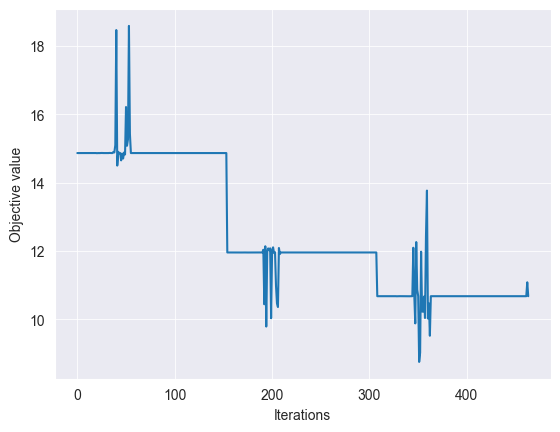

In [34]:
plt.plot(Residuals_over)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Objective value')
plt.grid(alpha=0.8)

In [35]:
Residuals_over[-1]

array(10.68039643)

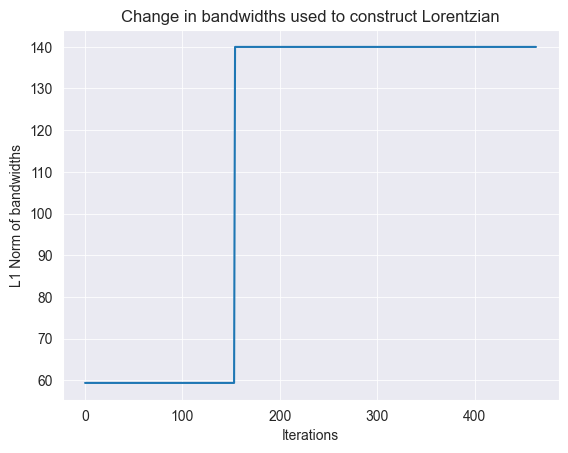

In [36]:
plt.plot(Values_of_bandwidth)
plt.grid()
plt.ylabel('L1 Norm of bandwidths')
plt.xlabel('Iterations')
plt.title('Change in bandwidths used to construct Lorentzian')
plt.grid(alpha=0.8)

In [15]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
Ti_filter_1,4.8211e-09,61614.0263,(1277997108290928.25%),4.821139727714767e-09,1.0000e-09,1.0000e-08,True
Ti_filter_2,3.4153e-09,nan,(nan%),3.4152768008097387e-09,1.0000e-09,1.0000e-08,True
Ti_filter_3,9.1584e-09,nan,(nan%),9.158379213991654e-09,1.0000e-09,1.0000e-08,True
Ti_filter_4,5.5071e-09,nan,(nan%),5.507147907251986e-09,1.0000e-09,1.0000e-08,True
Ti_filter_5,9.9000e-09,520816.505,(5260772774837923.00%),9.925592048008519e-09,1.0000e-09,1.0000e-08,True
Ti_filter_6,3.7398e-09,nan,(nan%),3.739823415880752e-09,1.0000e-09,1.0000e-08,True
Ti_filter_7,2.1263e-09,nan,(nan%),2.126272447360034e-09,1.0000e-09,1.0000e-08,True
Ti_filter_8,4.3767e-09,31102.1705,(710631861677585.88%),4.376692370837602e-09,1.0000e-09,1.0000e-08,True
Ti_filter_9,5.1138e-09,nan,(nan%),5.113816709945987e-09,1.0000e-09,1.0000e-08,True
Ti_filter_10,6.1961e-09,27599.1466,(445424655226697.38%),6.196142548984122e-09,1.0000e-09,1.0000e-08,True


In [143]:
save_success = save_results(result.params, Residuals_over, '_Nelder','/Users/jaworskj/DataspellProjects/General_purpose_hyperspectral_thermal_camera/Lorentzian_function_approach/Experimental_results',dtype,device)